In [1]:
# Cell 1: Imports and config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import xgboost as xgb

# Visual config
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,4)
sns.set(style='whitegrid')

# Create output folders
Path('data').mkdir(exist_ok=True)
Path('outputs').mkdir(exist_ok=True)
Path('outputs/plots').mkdir(exist_ok=True)


In [2]:
# Cell 2: Load the CSV
# Save your CSV in data/chennai_aqi.csv before running this cell.

input_path = Path('data/chennai_aqi.csv')
if not input_path.exists():
    raise FileNotFoundError(f"Place your CSV at: {input_path.resolve()}")

# Read CSV; the sample you provided has Date format 'dd/mm/yy' and header row.
df = pd.read_csv(input_path)

print("Columns found:", df.columns.tolist())
print("First 5 rows:")
display(df.head())


Columns found: ['City', 'Date', 'AQI', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
First 5 rows:


,City,Date,AQI,PM2.5,PM10,NO2,SO2,CO,O3
0,Chennai,01/01/18,93.0,51.15,100.44,77.19,106.02,0.98,88.35
1,Chennai,02/01/18,100.0,55.00,108.00,83.00,114.00,1.05,95.00
2,Chennai,03/01/18,81.0,44.55,87.48,67.23,92.34,0.85,76.95
3,Chennai,04/01/18,169.0,92.95,182.52,140.27,192.66,1.77,160.55
4,Chennai,05/01/18,153.0,84.15,165.24,126.99,174.42,1.61,145.35


In [3]:
# Cell 3: Clean column names & ensure datetime index

# Standardize column names (lowercase, strip, replace spaces/dots)
df.columns = [c.strip().lower().replace('.', '').replace(' ', '_') for c in df.columns]
print("Columns after cleaning:", df.columns.tolist())

# Ensure the index is datetime (your sample shows 'date' is already the index)
if not isinstance(df.index, pd.DatetimeIndex):
    try:
        df.index = pd.to_datetime(df.index, dayfirst=True, errors='coerce')
    except Exception as e:
        raise ValueError(f"❌ Failed to parse index as datetime: {e}")

# Drop rows with invalid dates (NaT)
df = df[~df.index.isna()].copy()

# Rename pollutant columns safely
col_map = {}
for c in df.columns:
    cname = c.replace('.', '').replace('_', '').lower()
    if cname in ('pm25', 'pm2.5', 'pm_2_5'):
        col_map[c] = 'pm25'
    elif cname == 'pm10':
        col_map[c] = 'pm10'
    elif cname == 'aqi':
        col_map[c] = 'aqi'
    elif cname == 'no2':
        col_map[c] = 'no2'
    elif cname == 'so2':
        col_map[c] = 'so2'
    elif cname == 'co':
        col_map[c] = 'co'
    elif cname == 'o3':
        col_map[c] = 'o3'

df = df.rename(columns=col_map)

# Ensure numeric for pollutant columns
for c in ['aqi', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

print("✅ After parsing:")
print(df.info())
print("Index range:", df.index.min(), "→", df.index.max())
print(df.head(3))


Columns after cleaning: ['city', 'date', 'aqi', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3']
✅ After parsing:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000002550
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    2551 non-null   object 
 1   date    2551 non-null   object 
 2   aqi     2550 non-null   float64
 3   pm25    2551 non-null   float64
 4   pm10    2551 non-null   float64
 5   no2     2551 non-null   float64
 6   so2     2551 non-null   float64
 7   co      2551 non-null   float64
 8   o3      2551 non-null   float64
dtypes: float64(7), object(2)
memory usage: 199.3+ KB
None
Index range: 1970-01-01 00:00:00 → 1970-01-01 00:00:00.000002550
                                  city      date    aqi   pm25    pm10    no2  \
1970-01-01 00:00:00.000000000  Chennai  01/01/18   93.0  51.15  100.44  77.19   
1970-01-01 00:00:00.000000001  Chennai  02/01/18

Shape: (2551, 9)
Missing percent by column:
city    0.00
date    0.00
aqi     0.04
pm25    0.00
pm10    0.00
no2     0.00
so2     0.00
co      0.00
o3      0.00
dtype: float64
Duplicate index entries: 0


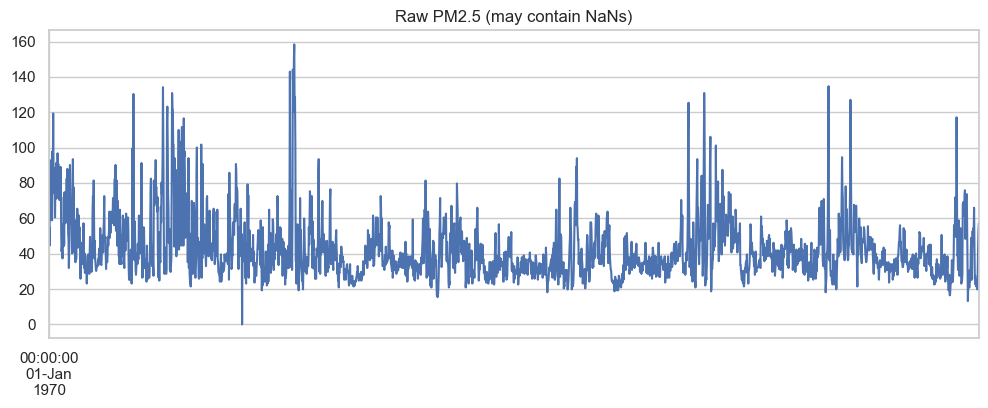

In [4]:
# Cell 4: Initial checks & missingness
print("Shape:", df.shape)
print("Missing percent by column:")
print((df.isna().mean()*100).round(2))

# Show any duplicate dates (shouldn't be for daily data)
print("Duplicate index entries:", df.index.duplicated().sum())

# Quick plot of raw pm25 (if exists)
if 'pm25' in df.columns:
    df['pm25'].plot(title='Raw PM2.5 (may contain NaNs)')
    plt.savefig('outputs/plots/pm25_raw.png', bbox_inches='tight')


In [34]:
# Cell 5: Resample to DAILY frequency and basic imputation

import os

# 🔎 Just check columns (date is already the index)
print("Index name:", df.index.name)
print("Available columns:", df.columns)

# ✅ Ensure DataFrame is sorted by datetime index
df = df.sort_index()

# ✅ Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include="number").columns
non_numeric_cols = df.select_dtypes(exclude="number").columns

# ✅ Resample numeric columns with daily mean
df_daily = df[numeric_cols].resample('D').mean()

# ✅ Add back non-numeric columns (like city/station) with forward fill
for col in non_numeric_cols:
    df_daily[col] = df[col].resample('D').ffill()

# ✅ Handle missing values:
# 1) Interpolate small numeric gaps
df_daily[numeric_cols] = df_daily[numeric_cols].interpolate(method='time')
# 2) Forward + backward fill as fallback
df_daily[numeric_cols] = df_daily[numeric_cols].ffill().bfill()

# ✅ Save resampled cleaned dataset
os.makedirs("outputs", exist_ok=True)  # ensure folder exists
df_daily.to_csv("outputs/chennai_aqi_resampled.csv", index=True)

print("✅ Saved cleaned daily dataset to outputs/chennai_aqi_resampled.csv")
print("Number of daily records:", len(df_daily))
display(df_daily.head())


Index name: date
Available columns: Index(['city', 'aqi', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3'], dtype='object')
✅ Saved cleaned daily dataset to outputs/chennai_aqi_resampled.csv
Number of daily records: 2557


,aqi,pm25,pm10,no2,so2,co,o3,city
date,,,,,,,,
2018-01-01,93.0,51.15,100.44,77.19,106.02,0.98,88.35,Chennai
2018-01-02,134.0,73.70,144.72,111.22,152.76,1.41,127.30,Chennai
2018-01-03,142.0,78.10,153.36,117.86,161.88,1.49,134.90,Chennai
2018-01-04,84.0,46.20,90.72,69.72,95.76,0.88,79.80,Chennai
2018-01-05,118.0,64.90,127.44,97.94,134.52,1.24,112.10,Chennai


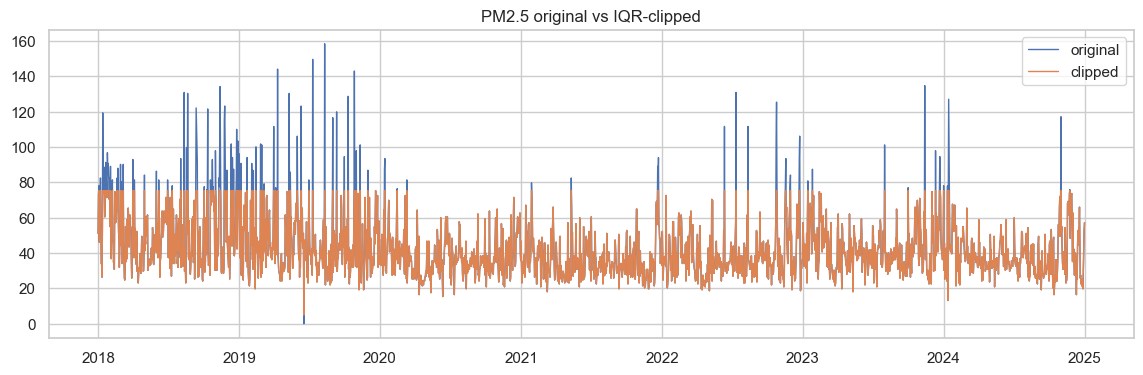

In [35]:
# Cell 6: Outlier checking (simple) and optional clipping
# NOTE: Be careful clipping; peaks may be real. We will only show IQR bounds and create clipped copy.

def iqr_clip(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return series.clip(lower, upper)

df_clip = df_daily.copy()
for col in ['pm25','pm10','no2','so2','co','o3','aqi']:
    if col in df_clip.columns:
        df_clip[col+'_clipped'] = iqr_clip(df_clip[col])

# Plot comparison for pm25 if exists
if 'pm25' in df_daily.columns:
    plt.figure(figsize=(14,4))
    plt.plot(df_daily.index, df_daily['pm25'], label='original', linewidth=1)
    plt.plot(df_clip.index, df_clip['pm25_clipped'], label='clipped', linewidth=1)
    plt.legend()
    plt.title('PM2.5 original vs IQR-clipped')
    plt.savefig('outputs/plots/pm25_clipped.png', bbox_inches='tight')


,count,mean,std,min,25%,50%,75%,max
aqi,2557.0,77.406727,31.766175,24.0,57.00,69.00,89.00,288.00
pm25,2557.0,42.555094,17.491389,0.0,31.35,37.95,48.95,158.40
pm10,2557.0,83.562730,34.346727,0.0,61.56,74.52,96.12,311.04
no2,2557.0,64.219505,26.396096,0.0,47.31,57.27,73.87,239.04
so2,2557.0,88.205104,36.254878,0.0,64.98,78.66,101.46,328.32
co,2557.0,0.812657,0.333990,0.0,0.60,0.72,0.93,3.02
o3,2557.0,73.504253,30.212399,0.0,54.15,65.55,84.55,273.60


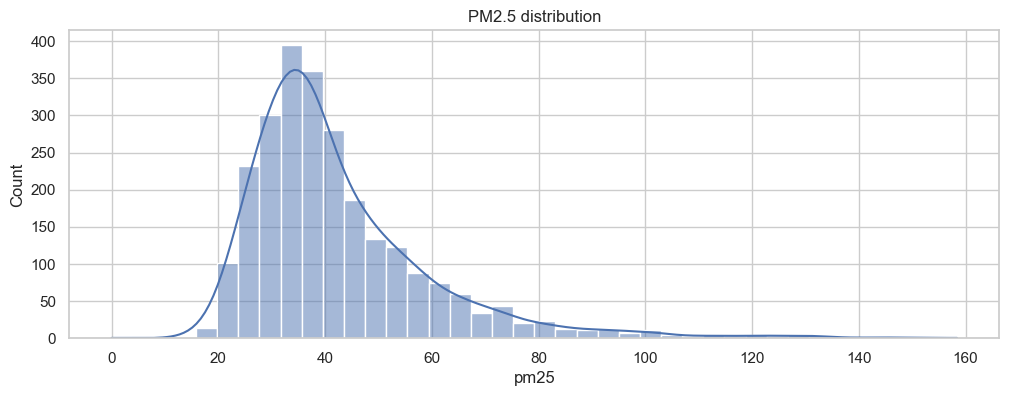

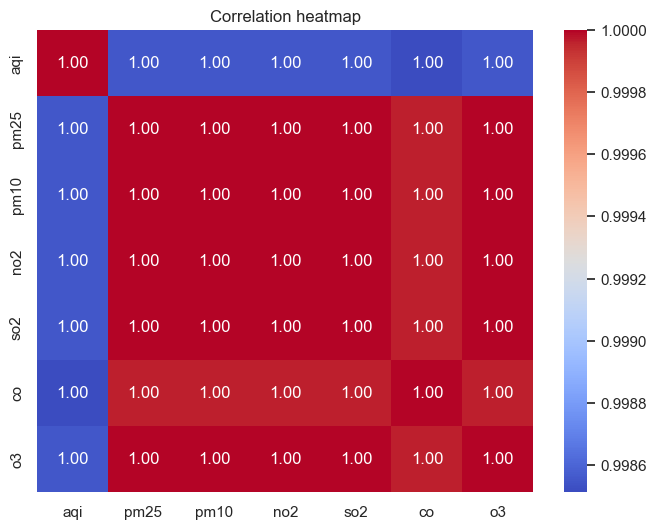

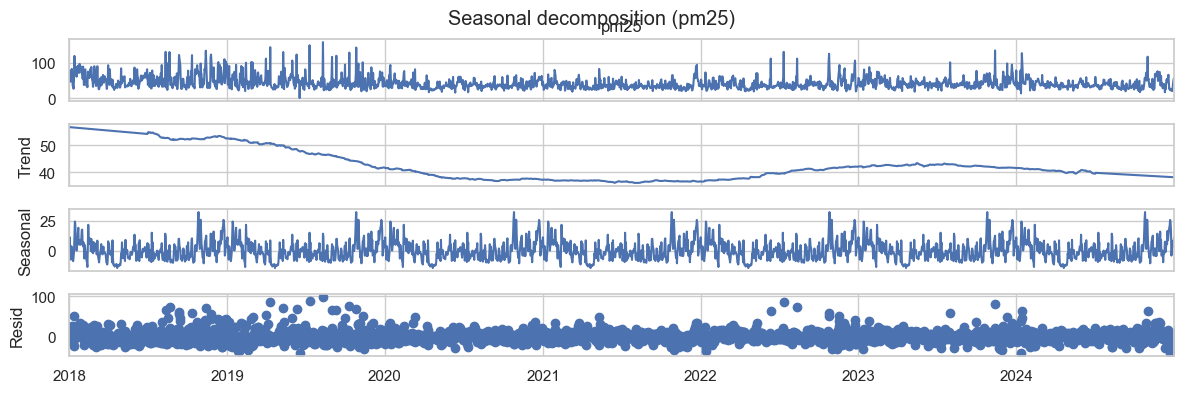

<Figure size 1200x400 with 0 Axes>

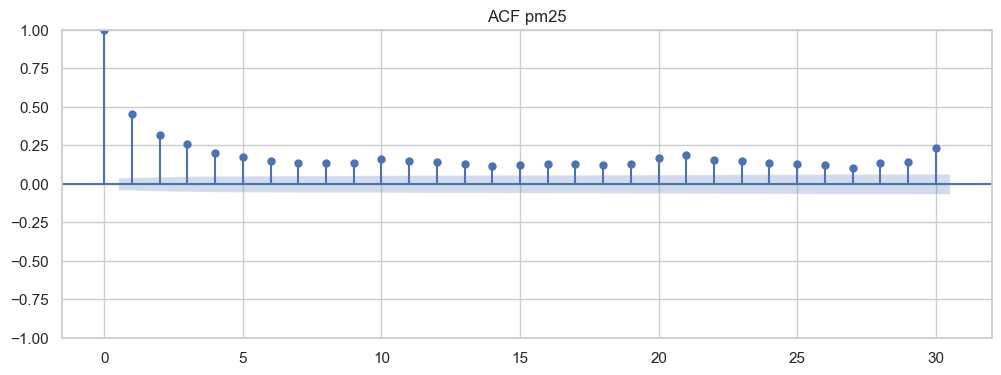

<Figure size 1200x400 with 0 Axes>

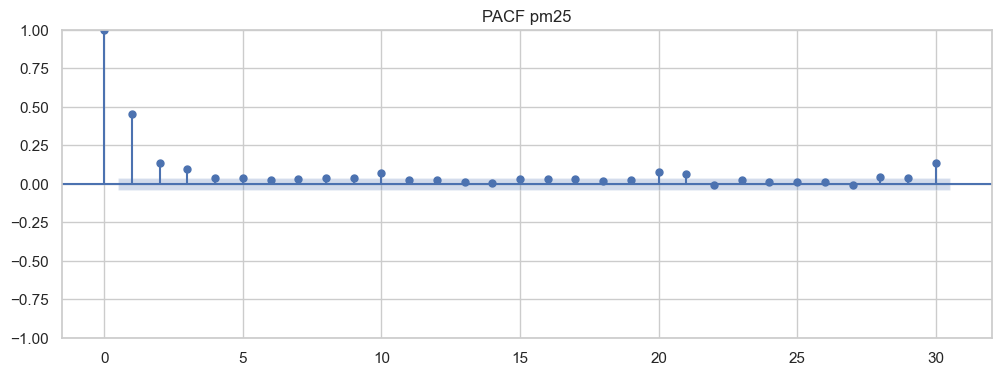

In [36]:
# Cell 7: EDA - distributions, seasonality, correlations

# 7.1 Summary stats
display(df_daily.describe().T)

# 7.2 Histogram of PM2.5
if 'pm25' in df_daily.columns:
    plt.figure()
    sns.histplot(df_daily['pm25'].dropna(), bins=40, kde=True)
    plt.title('PM2.5 distribution')
    plt.savefig('outputs/plots/pm25_hist.png', bbox_inches='tight')

# 7.3 Correlation heatmap (daily mean / already daily)
plt.figure(figsize=(8,6))
sns.heatmap(df_daily.select_dtypes(include=[np.number]).corr(),
            annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation heatmap')
plt.savefig('outputs/plots/correlation_heatmap.png', bbox_inches='tight')


# 7.4 Seasonal decomposition for pm25 (if enough data)
if 'pm25' in df_daily.columns and len(df_daily) > 365:
    s = df_daily['pm25'].interpolate()
    res = seasonal_decompose(s, period=365, model='additive', extrapolate_trend='freq')
    res.plot()
    plt.suptitle('Seasonal decomposition (pm25)')
    plt.savefig('outputs/plots/pm25_decompose.png', bbox_inches='tight')

# 7.5 ACF/PACF for pm25 (use lags up to 30 days)
if 'pm25' in df_daily.columns:
    plt.figure()
    plot_acf(df_daily['pm25'].dropna(), lags=30)
    plt.title('ACF pm25')
    plt.savefig('outputs/plots/pm25_acf.png', bbox_inches='tight')
    plt.figure()
    plot_pacf(df_daily['pm25'].dropna(), lags=30)
    plt.title('PACF pm25')
    plt.savefig('outputs/plots/pm25_pacf.png', bbox_inches='tight')


In [37]:
# Cell 8: Feature engineering - calendar features, lags, rolling stats, and target creation
X = df_daily.copy()

# Calendar / cyclical
X['dayofweek'] = X.index.dayofweek
X['is_weekend'] = X['dayofweek'].isin([5,6]).astype(int)
X['day'] = X.index.day
X['month'] = X.index.month
X['month_sin'] = np.sin(2*np.pi*X['month']/12)
X['month_cos'] = np.cos(2*np.pi*X['month']/12)

# Lags for target variable(s) - choose pm25 as primary target
target = 'pm25'
lags = [1,2,3,7,14,21,28]   # days
for lag in lags:
    X[f'{target}_lag_{lag}'] = X[target].shift(lag)

# Rolling means and std (shifted by 1 to avoid leakage)
X[f'{target}_roll_3_mean'] = X[target].rolling(window=3).mean().shift(1)
X[f'{target}_roll_7_mean'] = X[target].rolling(window=7).mean().shift(1)
X[f'{target}_roll_14_mean'] = X[target].rolling(window=14).mean().shift(1)
X[f'{target}_roll_7_std'] = X[target].rolling(window=7).std().shift(1)

# Differences
X[f'{target}_diff_1'] = X[target] - X[target].shift(1)

# Fourier-like small terms for annual seasonality (if daily)
t = np.arange(len(X))
if X.index.freq is None:
    # ensure index is regular; we resampled daily so freq should be D
    X = X.asfreq('D')

if X.shape[0] > 365:
    period = 365.25
    order = 3
    for k in range(1, order+1):
        X[f'sin_{k}'] = np.sin(2*np.pi*k*t/period)
        X[f'cos_{k}'] = np.cos(2*np.pi*k*t/period)

# External regressors: If meteo columns exist, you can add lagged versions similarly.
# For now we use only pollutant variables.

# Create supervised target: predict next day pm25 (H=1)
H = 1
X[f'target_t+{H}'] = X[target].shift(-H)

# Drop rows with NA introduced by shifting/rolling
X = X.dropna()

# Save features
X.to_csv('outputs/chennai_features.csv')
print("Saved features to outputs/chennai_features.csv")
display(X.head())


Saved features to outputs/chennai_features.csv


,aqi,pm25,pm10,no2,so2,co,o3,city,dayofweek,is_weekend,...,pm25_roll_14_mean,pm25_roll_7_std,pm25_diff_1,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,target_t+1
date,,,,,,,,,,,,,,,,,,,,,
2018-01-29,145.0,79.75,156.60,120.35,165.30,1.52,137.75,Chennai,0,0,...,80.575000,8.499405,-4.95,0.463258,0.886224,0.821100,0.570784,0.992099,0.125461,70.40
2018-01-30,128.0,70.40,138.24,106.24,145.92,1.34,121.60,Chennai,1,0,...,80.967857,8.654754,-9.35,0.478434,0.878124,0.840248,0.542202,0.997250,0.074117,82.50
2018-01-31,150.0,82.50,162.00,124.50,171.00,1.58,142.50,Chennai,2,0,...,80.692857,9.748242,12.10,0.493468,0.869764,0.858402,0.512978,0.999745,0.022576,55.00
2018-02-01,100.0,55.00,108.00,83.00,114.00,1.05,95.00,Chennai,3,0,...,80.260714,8.381648,-27.50,0.508356,0.861147,0.875539,0.483147,0.999579,-0.029025,89.10
2018-02-02,162.0,89.10,174.96,134.46,184.68,1.70,153.90,Chennai,4,0,...,79.867857,12.209622,34.10,0.523094,0.852275,0.891640,0.452745,0.996751,-0.080549,58.85


In [39]:
# Cell 9: Train-test split (time-based) and baseline persistence
# Use first 80% for training, last 20% for testing
n = len(X)
train_size = int(n * 0.8)
train = X.iloc[:train_size].copy()
test = X.iloc[train_size:].copy()

# Feature columns - exclude raw target at time t and exclude future target
exclude = [f'target_t+{H}', 'pm25']  # we include pm25_lag_* but drop current pm25 to avoid leakage
features = [c for c in X.columns if c not in exclude]

X_train = train[features]
y_train = train[f'target_t+{H}']
X_test = test[features]
y_test = test[f'target_t+{H}']

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Baseline: persistence (predict tomorrow = today)
y_pred_persist = test['pm25'].values  # because target_t+1 ~ today's pm25 (persistence)
mae_persist = mean_absolute_error(y_test, y_pred_persist)
print("Baseline persistence MAE:", mae_persist)


Train shape: (2022, 31) Test shape: (506, 31)
Baseline persistence MAE: 9.059782608695652


In [40]:
# Cell 10: Train a RandomForest pipeline and evaluate

# Drop non-numeric columns (like 'city') if still present
X_train_num = X_train.select_dtypes(include=['number'])
X_test_num = X_test.select_dtypes(include=['number'])

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

pipe.fit(X_train_num, y_train)
y_pred_rf = pipe.predict(X_test_num)

def mape(y_true, y_pred):
    eps = 1e-6  # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = mape(y_test.values, y_pred_rf)

print("RandomForest - MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.2f}%".format(mae_rf, rmse_rf, mape_rf))

# Save model pipeline
os.makedirs("outputs", exist_ok=True)
joblib.dump(pipe, 'outputs/rf_pipeline.joblib')
print("Saved RF pipeline to outputs/rf_pipeline.joblib")


RandomForest - MAE: 8.074, RMSE: 11.657, MAPE: 21.57%
Saved RF pipeline to outputs/rf_pipeline.joblib


day                  0.086390
o3                   0.046649
so2                  0.044681
pm25_lag_28          0.044325
co                   0.042443
pm25_roll_7_mean     0.041819
pm10                 0.041714
pm25_roll_14_mean    0.040967
no2                  0.040811
aqi                  0.040529
pm25_lag_21          0.038141
sin_1                0.036538
pm25_diff_1          0.036435
pm25_lag_7           0.036153
pm25_lag_14          0.035766
pm25_roll_7_std      0.035677
sin_2                0.034208
pm25_lag_2           0.033860
sin_3                0.033560
pm25_lag_1           0.029972
dtype: float64

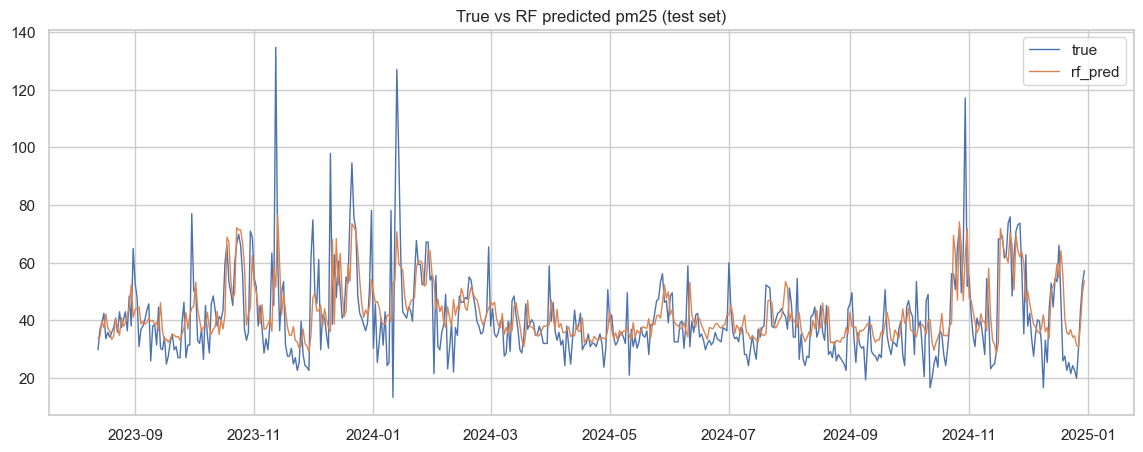

In [41]:
# Cell 11: Feature importance (from RF) and simple plots

rf = pipe.named_steps['rf']

# Only keep numeric columns used for training (same as X_train_num)
train_features = X_train_num.columns

# Map importances correctly
importances = pd.Series(rf.feature_importances_, index=train_features).sort_values(ascending=False)
display(importances.head(20))

# plot true vs predicted (test set)
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label='true', linewidth=1)
plt.plot(y_test.index, y_pred_rf, label='rf_pred', linewidth=1)
plt.legend()
plt.title('True vs RF predicted pm25 (test set)')
os.makedirs("outputs/plots", exist_ok=True)
plt.savefig('outputs/plots/pm25_true_vs_rf.png', bbox_inches='tight')


In [42]:
# Cell 12: Optional - XGBoost quick experiment (unscaled)

# Drop non-numeric columns like 'city'
X_train_xgb = X_train.select_dtypes(include=[np.number])
X_test_xgb = X_test.select_dtypes(include=[np.number])

xg = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

xg.fit(X_train_xgb, y_train)
y_pred_xgb = xg.predict(X_test_xgb)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mape(y_test.values, y_pred_xgb)

print("XGBoost - MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.2f}%".format(mae_xgb, rmse_xgb, mape_xgb))

# Save XGBoost model
os.makedirs("outputs", exist_ok=True)
joblib.dump(xg, 'outputs/xgboost_model.joblib')
print("Saved XGBoost to outputs/xgboost_model.joblib")


XGBoost - MAE: 8.174, RMSE: 11.871, MAPE: 21.29%
Saved XGBoost to outputs/xgboost_model.joblib


In [43]:
# Cell 13: Save summary metrics to a small CSV for your report
metrics = pd.DataFrame({
    'model': ['persistence','random_forest','xgboost'],
    'mae': [mae_persist, mae_rf, mae_xgb],
    'rmse': [np.nan, rmse_rf, rmse_xgb],
    'mape': [np.nan, mape_rf, mape_xgb]
})
metrics.to_csv('outputs/model_metrics.csv', index=False)
print("Saved metrics: outputs/model_metrics.csv")
display(metrics)


Saved metrics: outputs/model_metrics.csv


,model,mae,rmse,mape
0,persistence,9.059783,NaN,NaN
1,random_forest,8.074264,11.656901,21.57129
2,xgboost,8.174442,11.870680,21.28966


In [44]:
# Cell 14: Short conclusions & next steps (print to notebook)
print("""
Pipeline complete.

Files produced:
 - outputs/chennai_aqi_resampled.csv   (cleaned daily data)
 - outputs/chennai_features.csv        (feature matrix used for modeling)
 - outputs/rf_pipeline.joblib          (RandomForest pipeline)
 - outputs/xgboost_model.joblib        (XGBoost model)
 - outputs/model_metrics.csv           (evaluation metrics)
 - outputs/plots/                       (many PNG plots)

Next recommended steps:
 - Inspect feature importances and remove redundant features.
 - If available, merge meteorological data (temperature/humidity/wind).
 - Try TimeSeries cross-validation (sklearn's TimeSeriesSplit).
 - If you need multi-step forecasts, create multiple target columns (t+1..t+H).
""")



Pipeline complete.

Files produced:
 - outputs/chennai_aqi_resampled.csv   (cleaned daily data)
 - outputs/chennai_features.csv        (feature matrix used for modeling)
 - outputs/rf_pipeline.joblib          (RandomForest pipeline)
 - outputs/xgboost_model.joblib        (XGBoost model)
 - outputs/model_metrics.csv           (evaluation metrics)
 - outputs/plots/                       (many PNG plots)

Next recommended steps:
 - Inspect feature importances and remove redundant features.
 - If available, merge meteorological data (temperature/humidity/wind).
 - Try TimeSeries cross-validation (sklearn's TimeSeriesSplit).
 - If you need multi-step forecasts, create multiple target columns (t+1..t+H).

